In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib import pyplot as plt, dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [29]:
# Inspect the engine to find table names:
inspector = inspect(engine)
print(inspector.get_table_names())
# View all of the classes that automap found for 'station' table:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


['measurement', 'station']
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

Query Date Most Recent:  2017-08-23
Query Date Year Before:  2016-08-23


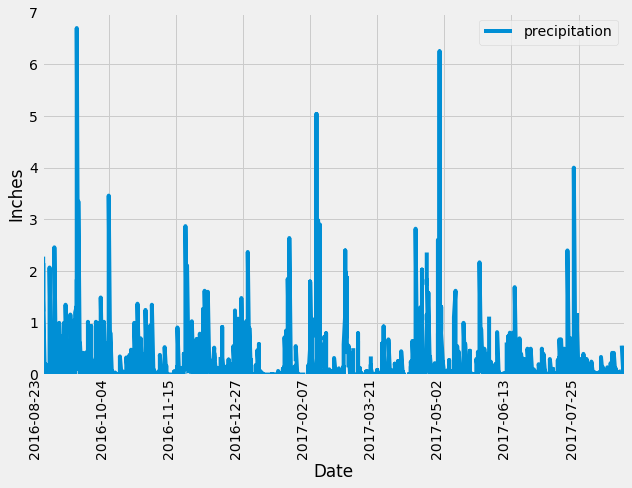

In [114]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
qry_date_recent = dt.date(2017, 8, 23)  
# Calculate the date one year from the last date in data set.
qry_date_yearBefore = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print("Query Date Most Recent: ", qry_date_recent)
print("Query Date Year Before: ", qry_date_yearBefore)

# Perform a query to retrieve the data and precipitation scores
prcp_date_qry = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= dt.date(2016, 8, 23)).\
    filter(measurement.date <= dt.date(2017, 8, 23)).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_date_qry, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)
prcp_df.index = pd.to_datetime(prcp_df.index, format="%Y/%m/%d")

# Sort the dataframe by date
prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# Set fig and axis, and figure size:
fig, ax = plt.subplots(figsize=(9, 7))
# pandas plot:
prcp_df_plot = prcp_df.plot(ax=ax, ylim=(0,7), rot=90)
# Format x label for dates: 
# Define the date format and set it to the x-axis:
date_form = mdates.DateFormatter("%Y-%m-%d") 
ax.set_xlim([dt.date(2016, 8, 23), dt.date(2017, 8, 23)])
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for every 6 weeks using (interval=6) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))

# Add titles:
plt.xlabel("Date")
plt.ylabel("Inches")

plt.tight_layout()
#  Save plot as png:
plt.savefig("Images/prcp_df_plot.png")
plt.show()


In [48]:
prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [93]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [115]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [130]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(station.station, func.count(measurement.station)).filter(measurement.station == station.station).group_by(station.station).\
    order_by(func.count(station.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()